<a href="https://colab.research.google.com/github/xx529/Reinforcement-Learning/blob/main/DQN/DQN%20version2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CartPole

1. DQN (double)
2. Q-Learning
3. memory replay


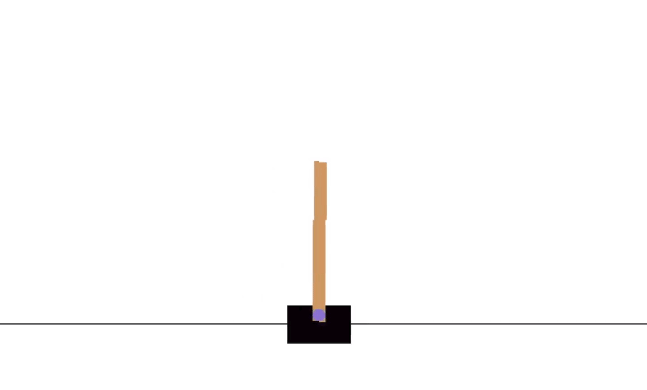



In [116]:
# !pip install pytorch-lightning

In [136]:
import gym
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch
import copy
import numpy as np
import torch.optim as optimizer
from IPython import display
import time
import pytorch_lightning as pl
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from pytorch_lightning import loggers as pl_loggers

In [118]:
env = gym.make('CartPole-v0')
obs = env.reset()
done = False

while not done:
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    # print(observation, reward, done, info, action)

## Memory Replay

In [119]:
class MemoryReplay:
    def __init__(self, memory_size, gamma=0.8):
        self.queue = []
        self.add_list = []
        self.gamma = gamma
        self.memory_size = memory_size
        
    def add(self, mc_sample_tuple): # (cur_obervation, action, reward, done)
        self.add_list.append(mc_sample_tuple)
        if mc_sample_tuple[3] == True:
            self.creat_memory()

    def creat_memory(self):
        next_state_value  = 0
        for (cur_obervation, action, reward, _) in self.add_list[::-1]:
            next_state_value = reward + self.gamma * next_state_value
            self.queue.append((cur_obervation, action, next_state_value))
            if len(self.queue) >= self.memory_size:
                self.queue.pop(0)
        self.add_list = []
    
    def sample(self, batch_size):
        if batch_size > len(self.queue):
            temp = self.queue
        else:
            temp = random.sample(self.queue, batch_size)
    
        
        x = torch.FloatTensor([np.r_[x[0], np.array(x[1])] for x in temp])
        y = torch.FloatTensor(np.array([x[-1] for x in temp]).reshape(-1, 1))

        dataset = TensorDataset(x, y)
        
        return DataLoader(dataset, 64, True)

    def __len__(self):
        return len(self.queue)

In [120]:
replay = MemoryReplay(1024)

env = gym.make('CartPole-v0')
current_observation = env.reset()
done = False

while True:
    action = env.action_space.sample()
    next_observation, reward, done, info = env.step(action)

    if done:
        replay.add((current_observation, action, -1, done))
        break
    else:
        replay.add((current_observation, action, reward, done))

    current_observation = next_observation

In [121]:
replay.sample(10)

## DQN

In [127]:
class DQN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.predict_state_value = nn.Sequential(
            nn.Linear(5, 64),
            nn.ReLU(),   
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x): 
        state_value = self.predict_state_value(x)
        return state_value

    def training_step(self, batch, batch_idx):
        x, y_true = batch
        y_hat = self.predict_state_value(x)
        loss = F.mse_loss(y_hat, y_true)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)

In [132]:
%load_ext tensorboard

In [145]:
dqn = DQN()

tb_logger = pl_loggers.TensorBoardLogger('logs/')
trainer = pl.Trainer(max_epochs=100, logger=tb_logger)
trainer.fit(dqn, replay.sample(100))

GPU available: False, used: False
TPU available: None, using: 0 TPU cores
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
  warnings.warn(*args, **kwargs)

  | Name                | Type       | Params
---------------------------------------------------
0 | predict_state_value | Sequential | 2.5 K 
---------------------------------------------------
2.5 K     Trainable params
0         Non-trainable params
2.5 K     Total params
0.010     Total estimated model params size (MB)


1

## Agent

In [151]:
class Agent:
    def __init__(self, DQN_net):
        self.net = DQN_net

    def learn(self, train_loader):
        trainer = pl.Trainer(max_epochs=100)
        trainer.fit(self.net, train_loader)


    def step(self, state):
        x = torch.FloatTensor([
                state + [0.0],
                state + [1.0]
                ])
        
        return self.net(x)

## Setting

In [153]:
# Envirement
envirement = gym.make('CartPole-v0')

# Replay
MEMORY_SIZE = 2000
replay = MemoryReplay(MEMORY_SIZE)

# DQN
model = DQN()

# Agent
agent = Agent(model)

# Others
BATCH_SIZE = 1024
GAMMA = 0.9

## RL Training

In [154]:
for i in range(1):
    while True:
        action = env.action_space.sample()
        next_observation, reward, done, info = env.step(action)

        if done:
            replay.add((current_observation, action, -1, done))
            break
        else:
            replay.add((current_observation, action, reward, done))

        current_observation = next_observation

    agent.learn(replay.sample(BATCH_SIZE))

GPU available: False, used: False
TPU available: None, using: 0 TPU cores
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
  warnings.warn(*args, **kwargs)

  | Name                | Type       | Params
---------------------------------------------------
0 | predict_state_value | Sequential | 2.5 K 
---------------------------------------------------
2.5 K     Trainable params
0         Non-trainable params
2.5 K     Total params
0.010     Total estimated model params size (MB)


In [150]:
x = 1

a = [1,2,3,4,5,x]
a

[1, 2, 3, 4, 5, 1]

## Playing

In [ ]:
reward_list = []

for i in range(500):

    # 初始状态
    done = False
    current_state = envirement.reset()
    reward_temp = 0

    while not done :

        # agent 使用value_net 获取下一步 action
        action = agent.step(current_state, E_THRESHOLD, 'value', 'max')

        # 从环境获取信息
        next_state, reward, done, info = envirement.step(action)
        reward_temp += reward

        # 进入下一个状态
        current_state = next_state
    reward_list.append(reward_temp)

print(np.array(reward_list).mean())

## Random Playing

In [ ]:
reward_list = []

for i in range(500):
    
    # 初始状态
    done = False
    current_state = envirement.reset()
    reward_temp = 0

    while not done :
        action = random.choice([0,1])

        # 从环境获取信息
        next_state, reward, done, info = envirement.step(action)
        reward_temp += reward

        # 进入下一个状态
        current_state = next_state
        reward_list.append(reward_temp)

print(np.array(reward_list).mean())

In [ ]:
next_state, reward, done, info = envirement.step(action)

In [ ]:
next_state

In [ ]:
reward

In [ ]:
done

In [ ]:
info

In [ ]:
data_batch[0]

(array([ 0.02894037, -0.02437702, -0.03604944, -0.0175876 ]),
 1,
 1.0,
 array([ 0.02845283,  0.17124288, -0.0364012 , -0.32142305]),
 False)